In [2]:
import sys

sys.path.append('/Users/tristenmarto/Documents/Studie/Thesis/Synthsonic_data_analysis')

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

from collections import Counter

from imblearn.datasets import fetch_datasets

from Evaluation import synthsonic

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import smote_variants as sv

In [4]:
# metrics 
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import (recall_score, roc_auc_score, confusion_matrix, precision_score, precision_recall_curve,
                             f1_score, balanced_accuracy_score, accuracy_score, average_precision_score)

In [5]:
_logger = logging.getLogger('smote_variants')
_logger.setLevel(logging.DEBUG)
_logger_ch = logging.StreamHandler()
_logger_ch.setFormatter(logging.Formatter(
    "%(asctime)s:%(levelname)s:%(message)s"))
_logger.addHandler(_logger_ch)

In [6]:
random_state = 5

In [47]:
def pca_plot(X,y) :
    
    x = StandardScaler().fit_transform(X)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    
    fig = plt.figure(figsize = (12,7))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(f'2 component PCA')

    counter = Counter(y)

    for label, _ in counter.items() :
        rowix = np.where(y == label)[0]
        ax.scatter(principalComponents[rowix, 0], principalComponents[rowix, 1], label=str(label), s=20, alpha=0.5)

    ax.legend()

    fig.show()
    print(counter)

In [42]:
def test_metrics(training, testing, y_training, y_testing, clf, title) :
    
    clf.fit(training,y_training)
    prediction = clf.predict(testing)
    proba = clf.predict_proba(testing)[:,1]

    f_dict = {
        'title': title,
        'balanced acc': balanced_accuracy_score(y_testing,prediction),
        'precision': precision_score(y_testing,prediction),
        'recall': recall_score(y_testing,prediction),
        'roc_auc_score': roc_auc_score(y_testing, proba),
        'f1_score': f1_score(y_testing, prediction, average='binary'),
        'geometric mean': geometric_mean_score(y_testing, prediction),
        'average precision': average_precision_score(y_testing, prediction)
    }

    return f_dict

In [43]:
def metrics_test(proportions,xdata,ydata, clf) :
    
    res = []
    
    for prop,data,target in zip(proportions,xdata,ydata) :
    
        clf.fit(data,target)

        prediction = clf.predict(X_test)
        proba = clf.predict_proba(X_test)[:,1]

        f_dict = {
            'proportion':prop,
            'balanced acc': balanced_accuracy_score(y_test,prediction),
            'precision': precision_score(y_test,prediction),
            'recall': recall_score(y_test,prediction),
            'roc_auc_score': roc_auc_score(y_test, proba),
            'f1_score': f1_score(y_test, prediction, average='binary'),
            'geometric mean': geometric_mean_score(y_test, prediction),
            'average precision' : average_precision_score(y_test, prediction)
        }

        res.append(f_dict)
    
    return pd.DataFrame(res)

# data checks

In [10]:
# loading imblearn optical digits dataset

isolet = fetch_datasets()['isolet']
libras_move = fetch_datasets()['libras_move']

isolet_X,isolet_y, isolet_name = isolet['data'], isolet['target'], isolet['DESCR']
libras_X,libras_y, libras_name = libras_move['data'], libras_move['target'], libras_move['DESCR']

Counter({-1: 7197, 1: 600})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, 'PCA: Isolet dataset')

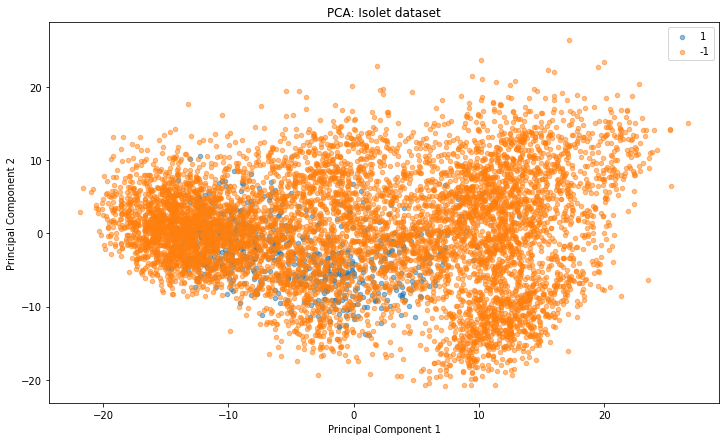

In [48]:
pca_plot(isolet_X,isolet_y)
plt.title("PCA: Isolet dataset")

In [67]:
isolet_X.shape

(7797, 617)

Counter({-1: 336, 1: 24})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, 'PCA: libras_move dataset')

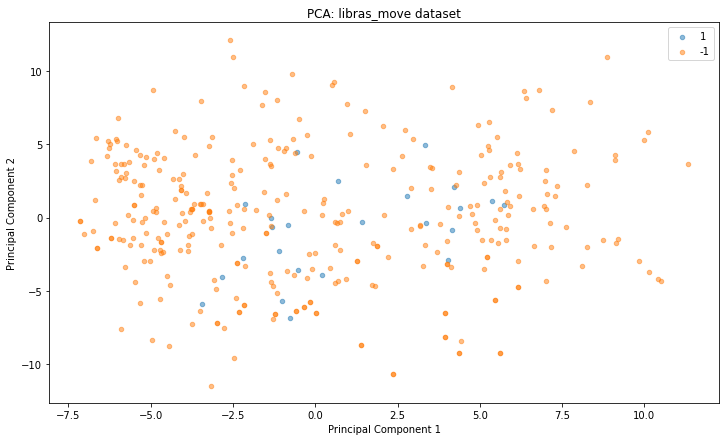

In [49]:
pca_plot(libras_X,libras_y)
plt.title('PCA: libras_move dataset')

array([[0.79691, 0.38194, 0.79691, ..., 0.3125 , 0.6383 , 0.29398],
       [0.67892, 0.27315, 0.68085, ..., 0.69213, 0.17215, 0.69213],
       [0.72147, 0.23611, 0.7234 , ..., 0.2662 , 0.78143, 0.27778],
       ...,
       [0.61122, 0.75926, 0.61122, ..., 0.52083, 0.44487, 0.5162 ],
       [0.65957, 0.79167, 0.65764, ..., 0.52546, 0.54159, 0.52083],
       [0.64023, 0.71991, 0.64217, ..., 0.49537, 0.52031, 0.49306]])

# Evaluation - Isolet

In [35]:
# base case
isolet_X_train, isolet_X_test, isolet_y_train, isolet_y_test = train_test_split(isolet_X, 
                                                                                isolet_y, 
                                                                                test_size=0.33, 
                                                                                random_state = random_state)

In [36]:
isolet_X_train.shape, isolet_X_test.shape

((5223, 617), (2574, 617))

In [55]:
clf = xgb.XGBClassifier(verbosity = 0, random_state=random_state)

cv_result = cross_validate(clf, isolet_X_train, isolet_y_train, scoring=[
                                                           "balanced_accuracy",
                                                           "precision",
                                                           "recall",
                                                           "roc_auc_ovr_weighted",
                                                           "f1",
                                                           "average_precision"
                                                           ])

/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboos

In [56]:
for key, data in cv_result.items() :
    print(key, data.mean())

fit_time 3.102407169342041
score_time 0.015093421936035157
test_balanced_accuracy 0.8620054044362482
test_precision 0.9199821863499362
test_recall 0.7291975308641976
test_roc_auc_ovr_weighted 0.9919471018390451
test_f1 0.8127987621637258
test_average_precision 0.9382974348704798


In [57]:
res_standard = test_metrics(isolet_X_train,isolet_X_test,isolet_y_train,isolet_y_test, clf, "No SMOTE")
res_standard

/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'title': 'No SMOTE',
 'balanced acc': 0.891928570970959,
 'precision': 0.9567901234567902,
 'recall': 0.7868020304568528,
 'roc_auc_score': 0.9957054598959145,
 'f1_score': 0.8635097493036212,
 'geometric mean': 0.8857115705430482,
 'average precision': 0.7691214281738817}

In [58]:
clf.fit(isolet_X_train,isolet_y_train)

prediction = clf.predict(isolet_X_test)

confusion_matrix(isolet_y_test,prediction)

/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


array([[2370,    7],
       [  42,  155]])

In [106]:
results = pd.DataFrame(res_standard, index=[0])
results

,title,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean,average precision
0,No SMOTE,0.891345,0.803922,0.803922,0.891345,0.803922,0.887047,0.665447


In [59]:
kneighbours = KNeighborsClassifier(3)
kneighbours.fit(isolet_X_train,isolet_y_train)

KNeighborsClassifier(n_neighbors=3)

In [60]:
res_k = test_metrics(isolet_X_train,isolet_X_test,isolet_y_train,isolet_y_test, kneighbours, "kneigbhours")
res_k = pd.DataFrame(res_k, index=[0])
res_k

,title,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean,average precision
0,kneigbhours,0.905067,0.848168,0.822335,0.977829,0.835052,0.901278,0.711075


In [62]:
predict_k = kneighbours.predict(isolet_X_test)
conf_k = confusion_matrix(isolet_y_test,predict_k)
conf_k

array([[2348,   29],
       [  35,  162]])

# Sample generation

In [63]:
proportions = [0.1, 0.25, 0.35, 0.5, 0.65, 0.8, 1]

In [64]:
samples_smote = []

for prop in proportions :
    o = sv.SMOTE(proportion = prop,
                   random_state = random_state)
    
    print(prop)
    x_g, y_g = o.sample(isolet_X_train,isolet_y_train)
    
    f_dict = {
        'prop':prop,
        'x_sample':x_g,
        'y_sample':y_g
    }
    
    samples_smote.append(f_dict)

2021-06-11 13:48:09,938:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:09,938:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:09,938:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


0.1


2021-06-11 13:48:10,197:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.25, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:10,197:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.25, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:10,197:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.25, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:10,365:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.35, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:10,365:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.35, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:10,365:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.35, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


0.25
0.35


2021-06-11 13:48:10,572:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:10,572:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:10,572:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:10,770:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.65, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:10,770:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.65, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:10,770:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.65, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


0.5
0.65


2021-06-11 13:48:10,985:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:10,985:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:10,985:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


0.8


2021-06-11 13:48:11,255:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:11,255:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 13:48:11,255:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


1


In [71]:
o = synthsonic(random_state = random_state,
               proportion = 1)

xt, yt = o.sample(isolet_X_train,isolet_y_train)

2021-06-11 15:16:33,653:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FF8EBFDF050}")
2021-06-11 15:16:33,653:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FF8EBFDF050}")
2021-06-11 15:16:33,653:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FF8EBFDF050}")
n_quantiles (500) is greater than the total number of samples (403). n_quantiles is set to num samples.


minority class 1, min dataset (403, 617)


ValueError: n_components=617 must be between 0 and min(n_samples, n_features)=403 with svd_solver='full'

In [65]:
samples_synth = []

for prop in proportions :
    o = synthsonic(distinct_threshold=3,
                   proportion = prop,
                   random_state = random_state)
    
    print(prop)
    x_g, y_g = o.sample(isolet_X_train,isolet_y_train)
    
    f_dict = {
        'prop':prop,
        'x_sample':x_g,
        'y_sample':y_g
    }
    
    samples_synth.append(f_dict)

2021-06-11 13:48:19,312:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'n_jobs': 1, 'distinct_threshold': 3, 'random_state': RandomState(MT19937) at 0x7FF907128050}")
2021-06-11 13:48:19,312:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'n_jobs': 1, 'distinct_threshold': 3, 'random_state': RandomState(MT19937) at 0x7FF907128050}")
2021-06-11 13:48:19,312:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'n_jobs': 1, 'distinct_threshold': 3, 'random_state': RandomState(MT19937) at 0x7FF907128050}")
n_quantiles (500) is greater than the total number of samples (403). n_quantiles is set to num samples.


0.1
minority class 1, min dataset (403, 617)


ValueError: n_components=613 must be between 0 and min(n_samples, n_features)=403 with svd_solver='full'

In [68]:
from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf

kde = KDECopulaNNPdf(use_KDE=False, clf=None)

kde.fit(isolet_X_train,isolet_y_train)

Building tree: 100%|██████████| 189420/189420.0 [05:18<00:00, 594.75it/s]
Generating for node: 12: 100%|██████████| 617/617 [09:49<00:00,  1.05it/s] 


KDECopulaNNPdf(clf=None)

In [69]:
xx = kde.sample_no_weights(n_samples=1000, mode='cheap')

Generating for node: 12: 100%|██████████| 617/617 [00:56<00:00, 10.97it/s] 


In [70]:
xx

array([[-0.78597247, -0.25095118, -0.14337349, ...,  0.16250206,
        -0.33001762, -0.688257  ],
       [-0.38051578, -0.19430086, -0.17563924, ..., -0.12275199,
        -0.10653263, -0.22282151],
       [-0.22916239,  0.2268222 ,  0.22661774, ..., -0.22731235,
        -0.4204886 , -0.79774223],
       ...,
       [-0.5448742 ,  0.02580644,  0.3393457 , ..., -0.34685841,
        -0.09816937, -0.42928883],
       [-0.45508687,  0.51397982,  0.49412451, ...,  0.3375222 ,
        -0.18494534, -0.74198611],
       [-0.62843165, -0.1574527 ,  0.13768759, ...,  0.54404071,
         0.29883923, -0.32246766]])

In [29]:
xs_smote = [samples_smote[i]['x_sample'] for i in range(len(proportions))]
ys_smote = [samples_smote[i]['y_sample'] for i in range(len(proportions))]

In [30]:
xs_synth = [samples_synth[i]['x_sample'] for i in range(len(proportions))]
ys_synth = [samples_synth[i]['y_sample'] for i in range(len(proportions))]

# Plots - SMOTE

Counter({-1: 1928, 1: 538})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (SMOTE 1:0.2 oversample)')

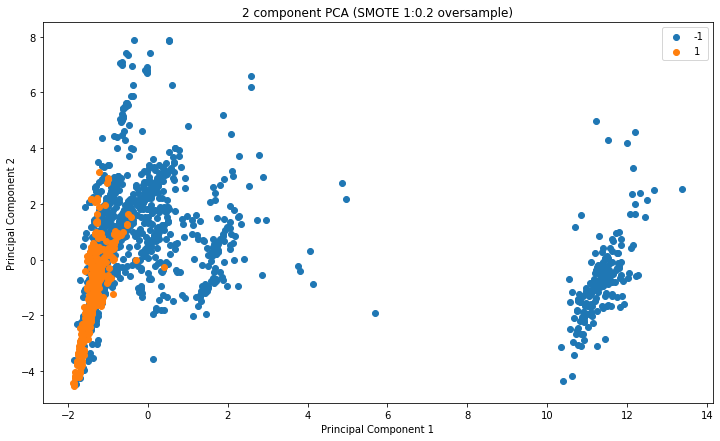

In [31]:
# 0.2
X,y = samples_smote[1]['x_sample'],samples_smote[1]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (SMOTE 1:0.2 oversample)")

Counter({-1: 1928, 1: 1059})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (SMOTE 1:0.5 oversample)')

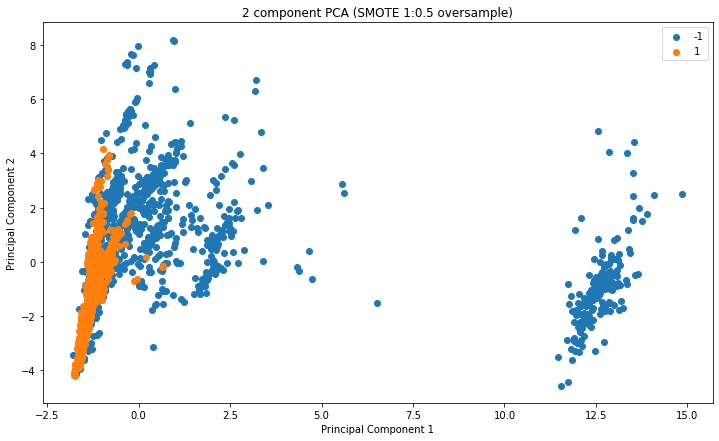

In [32]:
# 0.5
X,y = samples_smote[4]['x_sample'],samples_smote[4]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (SMOTE 1:0.5 oversample)")

Counter({-1: 1928, 1: 1928})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (SMOTE 1:1 oversample)')

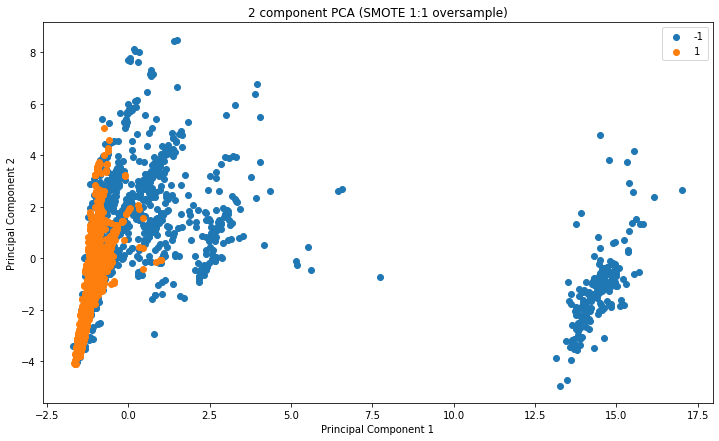

In [33]:
# 1
X,y = samples_smote[-1]['x_sample'],samples_smote[-1]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (SMOTE 1:1 oversample)")

# Plots synthsonic 

Counter({-1: 1928, 1: 538})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (Synthsonic 1:0.2 oversample)')

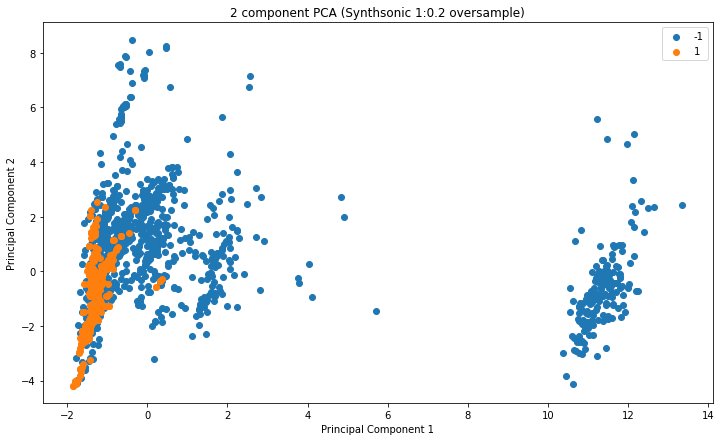

In [34]:
# 0.2

X,y = samples_synth[1]['x_sample'],samples_synth[1]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (Synthsonic 1:0.2 oversample)")

Counter({-1: 1928, 1: 1059})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (Synthsonic 1:0.5 oversample)')

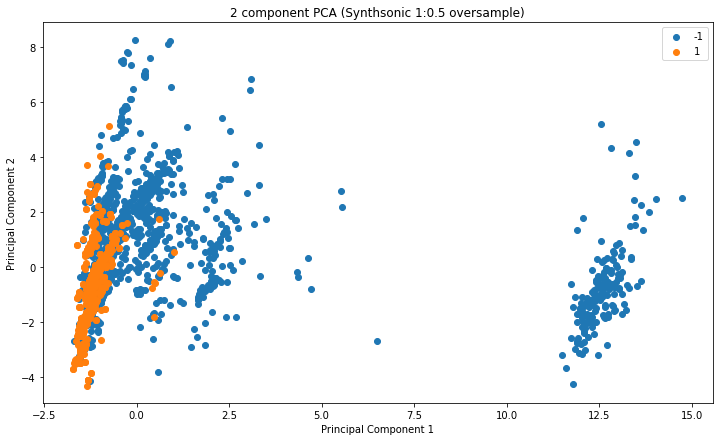

In [35]:
# 0.5

X,y = samples_synth[4]['x_sample'],samples_synth[4]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (Synthsonic 1:0.5 oversample)")

Counter({-1: 1928, 1: 1928})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (Synthsonic 1:1 oversample)')

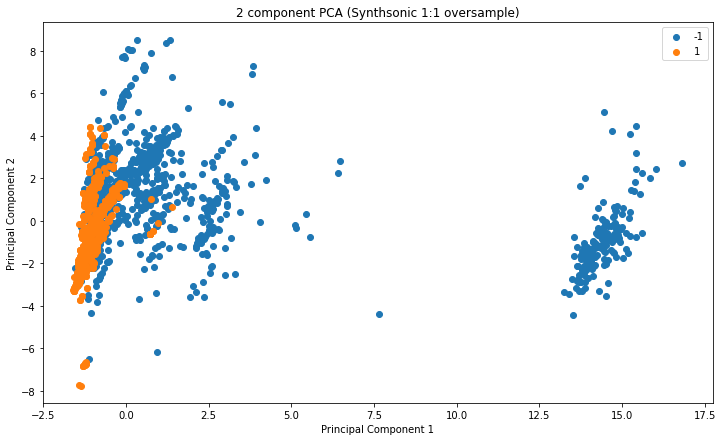

In [36]:
# 1

X,y = samples_synth[-1]['x_sample'],samples_synth[-1]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (Synthsonic 1:1 oversample)")

## metrics - decision tree

In [110]:
results

,title,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean,average precision
0,No SMOTE,0.891345,0.803922,0.803922,0.891345,0.803922,0.887047,0.665447


In [122]:
conf_mat(X_train,y_train,X_test,y_test, clf)

array([[922,  20],
       [ 20,  82]])

In [111]:
result_smote = metrics_test(proportions,xs_smote,ys_smote, clf)
result_smote

,proportion,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean,average precision
0,0.1,0.900087,0.792453,0.823529,0.900087,0.807692,0.896826,0.669850
1,0.2,0.910547,0.743590,0.852941,0.910547,0.794521,0.908723,0.648606
2,0.3,0.890284,0.788462,0.803922,0.890284,0.796117,0.886085,0.653018
3,0.4,0.905520,0.801887,0.833333,0.905520,0.817308,0.902638,0.684523
4,0.5,0.899026,0.777778,0.823529,0.899026,0.800000,0.895850,0.657764
5,0.6,0.908830,0.781818,0.843137,0.908830,0.811321,0.906452,0.674506
6,0.7,0.900618,0.800000,0.823529,0.900618,0.811594,0.897313,0.676065
7,0.8,0.917041,0.765217,0.862745,0.917041,0.811060,0.915433,0.673598
8,0.9,0.915324,0.805556,0.852941,0.915324,0.828571,0.913196,0.701459
9,1.0,0.905645,0.741379,0.843137,0.905645,0.788991,0.903485,0.640410


In [124]:
conf_mat(xs_smote[2],ys_smote[2], X_test, y_test, clf)

array([[920,  22],
       [ 20,  82]])

In [123]:
conf_mat(xs_smote[-1],ys_smote[-1], X_test, y_test, clf)

array([[912,  30],
       [ 16,  86]])

In [112]:
result_synth = metrics_test(proportions,xs_synth,ys_synth, clf)
result_synth

,proportion,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean,average precision
0,0.1,0.936649,0.773109,0.901961,0.936649,0.832579,0.936007,0.706893
1,0.2,0.910422,0.803738,0.843137,0.910422,0.822967,0.907932,0.692987
2,0.3,0.925784,0.756303,0.882353,0.925784,0.814480,0.924764,0.678820
3,0.4,0.940365,0.821429,0.901961,0.940365,0.859813,0.939580,0.750475
4,0.5,0.945797,0.830357,0.911765,0.945797,0.869159,0.945185,0.765711
5,0.6,0.946984,0.783333,0.921569,0.946984,0.846847,0.946643,0.729558
6,0.7,0.923130,0.725806,0.882353,0.923130,0.796460,0.922229,0.651912
7,0.8,0.904583,0.728814,0.843137,0.904583,0.781818,0.902494,0.629816
8,0.9,0.934401,0.805310,0.892157,0.934401,0.846512,0.933446,0.728999
9,1.0,0.935588,0.760331,0.901961,0.935588,0.825112,0.934983,0.695367


In [120]:
conf_mat(xs_synth[2],ys_synth[2], X_test, y_test, clf)

array([[913,  29],
       [ 12,  90]])

# metrics - kneigbhours

In [113]:
def conf_mat(x_train, y_train, x_test, y_test, clf) :
    
    clf.fit(x_train,y_train)
    
    pred = clf.predict(x_test)
    
    return confusion_matrix(y_test,pred)

In [114]:
res_k

,title,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean,average precision
0,kneigbhours,0.594043,0.458333,0.215686,0.697359,0.293333,0.457966,0.175485


In [115]:
conf_k

array([[916,  26],
       [ 80,  22]])

In [116]:
result_smote_k = metrics_test(proportions,xs_smote,ys_smote, kneighbours)
result_smote_k

,proportion,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean,average precision
0,0.1,0.659579,0.344538,0.401961,0.716737,0.371041,0.607188,0.196920
1,0.2,0.651586,0.257143,0.441176,0.697130,0.324910,0.616678,0.168043
2,0.3,0.651836,0.241026,0.460784,0.696349,0.316498,0.623209,0.163743
3,0.4,0.657113,0.225664,0.500000,0.694902,0.310976,0.638054,0.161682
4,0.5,0.663732,0.226496,0.519608,0.694580,0.315476,0.647895,0.164624
5,0.6,0.645841,0.210970,0.490196,0.704701,0.294985,0.626806,0.153225
6,0.7,0.656956,0.210117,0.529412,0.701277,0.300836,0.644456,0.157215
7,0.8,0.654021,0.197880,0.549020,0.696162,0.290909,0.645538,0.152701
8,0.9,0.643031,0.194139,0.519608,0.689454,0.282667,0.631075,0.147811
9,1.0,0.652835,0.200000,0.539216,0.690287,0.291777,0.642872,0.152862


In [117]:
conf_mat(xs_smote[2], ys_smote[2], X_test, y_test, kneighbours)

array([[794, 148],
       [ 55,  47]])

In [118]:
result_synth_k = metrics_test(proportions,xs_synth,ys_synth, kneighbours)
result_synth_k

,proportion,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean,average precision
0,0.1,0.631635,0.340000,0.333333,0.717310,0.336634,0.556757,0.178467
1,0.2,0.634382,0.267123,0.382353,0.704810,0.314516,0.582170,0.162480
2,0.3,0.679811,0.289017,0.490196,0.754808,0.363636,0.652832,0.191484
3,0.4,0.669976,0.245283,0.509804,0.733431,0.331210,0.650548,0.172939
4,0.5,0.675253,0.230453,0.549020,0.721671,0.324638,0.663349,0.170584
5,0.6,0.692862,0.233716,0.598039,0.757769,0.336088,0.686343,0.179044
6,0.7,0.684901,0.221014,0.598039,0.736741,0.322751,0.679370,0.171447
7,0.8,0.693768,0.220690,0.627451,0.741820,0.326531,0.690591,0.174870
8,0.9,0.715874,0.221875,0.696078,0.766132,0.336493,0.715600,0.184136
9,1.0,0.686961,0.194915,0.676471,0.736262,0.302632,0.686881,0.163464


In [119]:
conf_mat(xs_synth[2],ys_synth[2], X_test, y_test, kneighbours)

array([[819, 123],
       [ 52,  50]])

# precision recall curve